# Data analysis example SPAD-FCS on Alexa488AB

Files and folders needed:
* **"05_Alexa488AB_20ugmL_P60percP_SPAD.bin"**: contains the raw data
* **"05_Alexa488AB_20ugmL_P60percP_SPAD_info.txt"**: contains the metadata
* **"05_Alexa488AB_20ugmL_P60percP_SPAD_xcorrs/**: folder with 625 .csv files containing the 25x25 cross-correlations. The cross-correlations can be calculated from the .bin file as well, but this will take several hours

All data can be found [here](https://doi.org/10.5281/zenodo.4161418).

## Import modules

In [30]:
from brighteyes_ffs.fcs.fcs2corr import fcs_load_and_corr_split, fcs_crosscenter_av, fcs_spatialcorrav, fcs_sparse_matrices
from brighteyes_ffs.fcs.fcs_fit import fcs_fit, g2global_fit_struct, fcs_fit_dualfocus
from brighteyes_ffs.fcs.plot_airy import plot_airy
from brighteyes_ffs.fcs.fcs_load_g import load_g

from brighteyes_ffs.tools.fit_gauss_2d import fit_gauss_2d
from brighteyes_ffs.tools.find_nearest import find_nearest

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# from brighteyes_ffs.fcs_gui.read_ffs



## Open data and calculate correlations
The .bin file is opened, divided in chunks of 10 s each (20 chunks in total), the correlations for each chunk are calculated, and then averaged.

Possible values for listOfCorrelations:
* **central**: calculate G_12
* **sum3**: sum for each time bin the signal of the 9 most central pixels (3x3 square) and calculate G_sum3x3
* **sum5**: sum for each time bin the signal of alls pixels (5x5 square) and calculate G_sum5x5
* **allbuthot**: same as sum5, but without using the signal of pixel 1 (hot pixel)

'G' is an object that contains all correlations of all chunks, as well as the average for each configuration. 'data' contains the time trace of the last chunk.

Note: this will take several minutes

In [27]:
folder = r"C:\Users\eslenders\OneDrive - Fondazione Istituto Italiano Tecnologia\SPAD-FCS\Data\20200302 Alexa488AB"
file_name = r"\05_Alexa488AB_20ugmL_P60percP_SPAD.bin"
file_name_meta = "05_Alexa488AB_20ugmL_P60percP_SPAD_info.txt"
list_of_correlations = ['central', 'sum3', 'allbuthot']
chunksize = 10 # s
corr_res = 50 # 'resolution' of the correlation function: the higher this number, the more lag times are used

[G, data] = fcs_load_and_corr_split(folder + file_name, list_of_correlations, corr_res, chunksize)

## Plot airy pattern

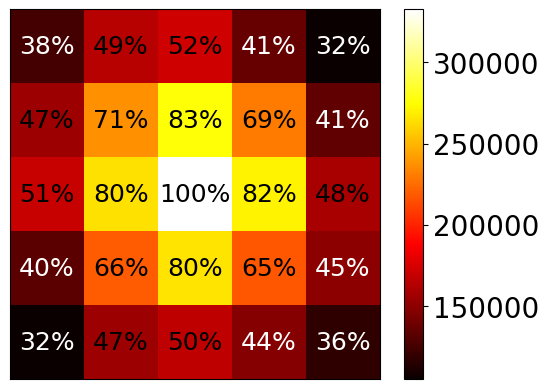

In [4]:
dummy = plot_airy(data)

## Fit correlations
Order of parameters: [N, tauD1, tauD2, F, alpha, T, tautrip, SF, offset, A, B] with
* **N**: average  number of particles in the focal volume
* **tauD1**: diffusion time first species [ms]
* **tauD2**: diffusion time second species (if any) [ms]
* **F**: fraction of species 1
* **alpha**: relative molecular brightness of species 1 with respect to species 2
* **T**: fraction in triplet state
* **tautrip**: residence time in triplet state [µs]
* **SF**: shape factor
* **offset**
* **A, B**: afterpulsing properties

### 1. by cropping the afterpulse effect

0.5
0.5
0.5


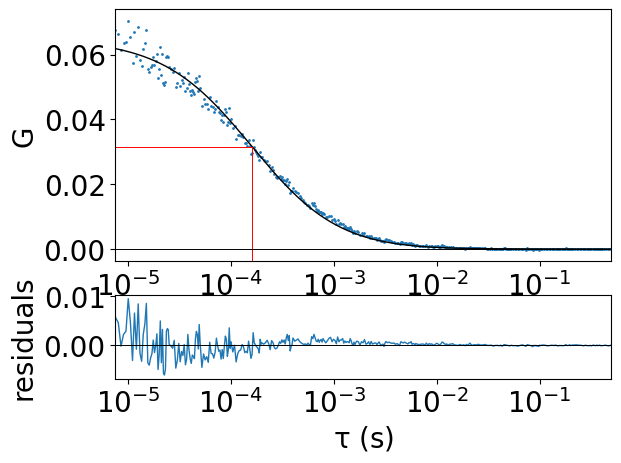

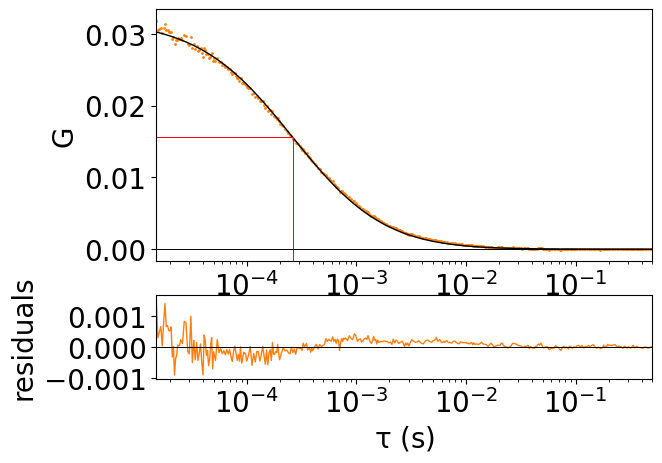

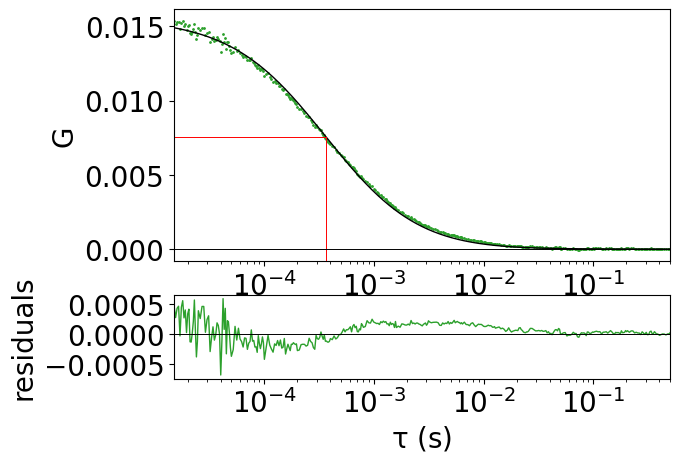

In [9]:
start = 15 # start index to fit the data, set to 15-30 to remove the afterpulse component at short lag times
fitarray = np.array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]) # parameters to fit
minBound = np.array([0, 5e-2, 5e-2, 0, 0, 0, 0, 0, 0, 0, 0]) # minimum values for the parameters
maxBound = np.array([1e6, 10, 10, 1, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6]) # maximum values for the parameters

# ---------- central element ----------
SF = 4.5 # shape factor, i.e. z0/w0 with z0 the height of the PSF and w0 the width (1/e^2 radius of the intensity)
startValues = np.array([70, 0.4, 0.8e-10, 1, 1, 0, 1e-6, SF, 0, 0, 1.05]) # start values for the fit
plotInfo = "central" # used for the color of the output plot
Gexp = G.central_average[:, 1]
tau = G.central_average[:, 0]
fitresult1 = fcs_fit(Gexp[start:], tau[start:], 'fitfun_2c', fitarray, startValues,  minBound, maxBound, plotInfo, 0, 0)

# ---------- sum3x3 ----------
SF = 4.1
startValues = np.array([70, 0.4, 0.8e-10, 1, 1, 0, 1e-6, SF, 0, 0, 1.05]) # start values for the fit
start = 30
plotInfo = "sum3"
Gexp = G.sum3_average[:, 1]
tau = G.sum3_average[:, 0]
fitresult3 = fcs_fit(Gexp[start:], tau[start:], 'fitfun_2c', fitarray, startValues,  minBound, maxBound, plotInfo, 0, 0)

# ---------- sum5x5 ----------
SF = 4.1
startValues = np.array([70, 0.4, 0.8e-10, 1, 1, 0, 1e-6, SF, 0, 0, 1.05]) # start values for the fit
start = 30
plotInfo = "sum5"
Gexp = G.allbuthot_average[:, 1]
tau = G.allbuthot_average[:, 0]
fitresult5 = fcs_fit(Gexp[start:], tau[start:], 'fitfun_2c', fitarray, startValues,  minBound, maxBound, plotInfo, 0, 0)

In [11]:
w0 = np.array([141e-9, 184e-9, 218e-9])
tau = 1e-3 * np.array([fitresult1.x[1], fitresult3.x[1], fitresult5.x[1]])
D = w0**2 / 4 / tau
print("D = " + str(D) + "µm^2/s")

D = [1.36027642e-11 3.20389176e-11 3.25163605e-11]µm^2/s


### 2. by using an afterpulse factor in the fit model

0.5
0.5
0.5


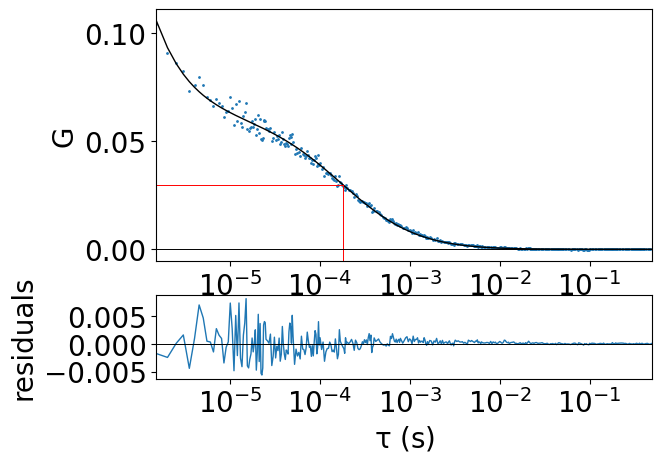

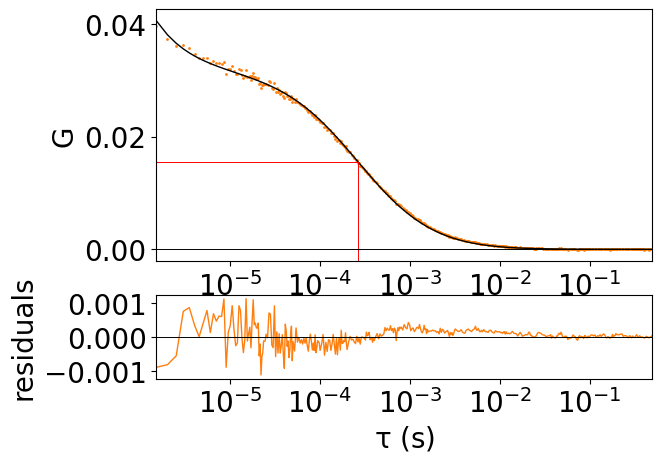

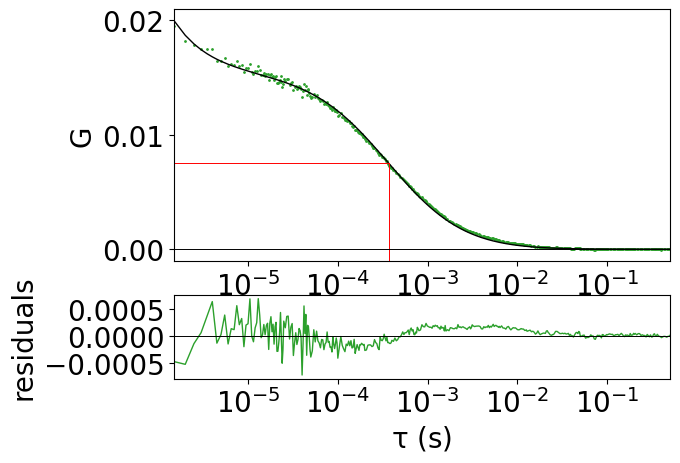

In [13]:
fitarray = np.array([1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0])
B = -1.103 # afterpulse 'lifetime'
minbound = np.array([0, 4.2e-2, 5e-2, 0, 0, 0, 0, 0, 0, 0, 0])
maxbound = np.array([1e6, 10, 10, 1, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6])
                    
# ---------- central element ----------
SF = 4.5 # shape factor, i.e. z0/w0 with z0 the height of the PSF and w0 the width (1/e^2 radius of the intensity)
startValues = np.array([70, 0.4, 0.8e-10, 1, 1, 0, 1e-6, SF, 0, 1, np.abs(B)]) # start values for the fit
start = 3
plotInfo = "central" # used for the color of the output plot
Gexp = G.central_average[:, 1]
tau = G.central_average[:, 0]
fitresultAP1 = fcs_fit(Gexp[start:], tau[start:], 'fitfun_2c', fitarray, startValues,  minBound, maxBound, plotInfo, 0, 0)

# ---------- sum3x3 ----------
SF = 4.1 # shape factor, i.e. z0/w0 with z0 the height of the PSF and w0 the width (1/e^2 radius of the intensity)
startValues = np.array([70, 0.4, 0.8e-10, 1, 1, 0, 1e-6, SF, 0, 1, np.abs(B)]) # start values for the fit
start = 3
plotInfo = "sum3" # used for the color of the output plot
Gexp = G.sum3_average[:, 1]
tau = G.sum3_average[:, 0]
fitresultAP3 = fcs_fit(Gexp[start:], tau[start:], 'fitfun_2c', fitarray, startValues,  minBound, maxBound, plotInfo, 0, 0)

# ---------- sum5x5 ----------
SF = 4.1 # shape factor, i.e. z0/w0 with z0 the height of the PSF and w0 the width (1/e^2 radius of the intensity)
startValues = np.array([70, 0.4, 0.8e-10, 1, 1, 0, 1e-6, SF, 0, 1, np.abs(B)]) # start values for the fit
start = 3
plotInfo = "sum5" # used for the color of the output plot
Gexp = G.allbuthot_average[:, 1]
tau = G.allbuthot_average[:, 0]
fitresultAP5 = fcs_fit(Gexp[start:], tau[start:], 'fitfun_2c', fitarray, startValues,  minBound, maxBound, plotInfo, 0, 0)

## Pair-correlation analysis

First, the cross-correlations between all possible pixel pairs are calculated. For pair-correlation analysis, only the cross-correlations with pixel 12 are then used. For iMSD, also the other correlations are used.

**Note**: this may take several hours. Alternatively, one can import the *.csv files with the cross-correlations already calculated.

In [21]:
useCSV = False # if true, use pre-calculated cross-correlations stored in .csv files, otherwise, calculate all correlations

In [34]:
if useCSV:
    # import correlations from .csv files (625 files)
    # load_g takes the "root" of the file names as input
    G = load_g("05_Alexa488AB_20ugmL_P60percP_SPAD_")
    G = fcs_spatialcorrav(G) # add field with STICS type cross-correlations
else:
    # calculate correlations
    file_name = r"\05_Alexa488AB_20ugmL_P60percP_SPAD.bin"
    file_name_meta = "05_Alexa488AB_20ugmL_P60percP_SPAD_info.txt"
    chunksize = 10 # s
    corr_res = 10 # 'resolution' of the correlation function: the higher this number, the more lag times are used
    [G, data] = fcs_sparse_matrices(folder + file_name, corr_res, chunksize, return_obj=True) # faster way to calculate all cross correlations

+-----------------------
| Loading chunk 0
+-----------------------
Elements: 40000000
Positions: 20000000
Freeing memory
Done.
data table: (20000000, 2)
Converting data to counts
Done.
+-----------------------
| Loading chunk 1
+-----------------------
Elements: 40000000
Positions: 20000000
Freeing memory
Done.
data table: (20000000, 2)
Converting data to counts
Done.
+-----------------------
| Loading chunk 2
+-----------------------
Elements: 40000000
Positions: 20000000
Freeing memory
Done.
data table: (20000000, 2)
Converting data to counts
Done.
+-----------------------
| Loading chunk 3
+-----------------------
Elements: 40000000
Positions: 20000000
Freeing memory
Done.
data table: (20000000, 2)
Converting data to counts
Done.
+-----------------------
| Loading chunk 4
+-----------------------
Elements: 40000000
Positions: 20000000
Freeing memory
Done.
data table: (20000000, 2)
Converting data to counts
Done.
+-----------------------
| Loading chunk 5
+-----------------------
El

Average all cross-correlations that have equal inter-pixel distances and store the resulting five pair-correlations (+ autocorrelation central element) in G.

In [32]:
G = fcs_crosscenter_av(G)

AttributeError: 'Correlations' object has no attribute 'det12x12_chunk0'

Prepare the data for fitting.

Order of parameters: [c, D, w0, ..., wN, SF0, ..., SFN, rhox0, ..., rhoxN, rhoy0, ..., rhoyN, vx, vy, dc0, ..., dcN] with
* **c**: concentration of the fluorophores
* **D**: diffusion coefficient
* **w0, ..., wn**: 1e/^2 radii of the PSFs. We assume they are all identical.
* **SF0, ..., SFN**: z0/w0 shape factor of the PSFs. We assume they are all identical.
* **rhox0, ..., rhoxN**: horizontal shift between the pixels for the different cross-correlations (e.g. 1 for neighbouring pixels, sqrt(2) for diagonally neighbouring pixels, etc.). Since only the absolute shifts are important and not the direction, we assume the absolute shifts are entirely in the x-direction, and set all shift in the y-direction to 0
* **rhoy0, ..., rhoyN**: shifts in the y direction. Set to 0
* **vx, vy**: flow of the particles (if not only free diffusion) in the x, y direction
* **dc0, ..., dcN**: offset of the correlation functions

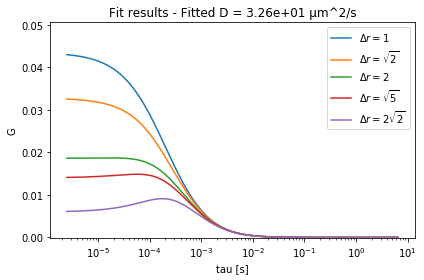

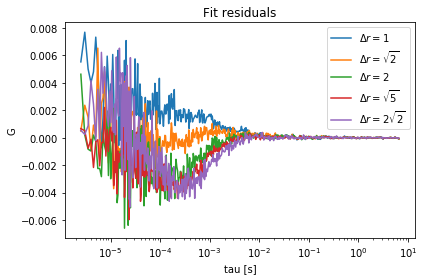

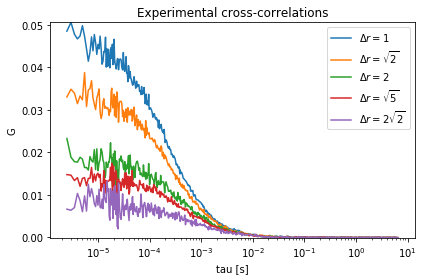

In [10]:
pxsize = 75e-9 # SPAD pixel size in the sample plane
w0Central = 141e-9 # 1/e^2 radius of the central SPAD pixel
SFCentral = 4.5 # shape factor of the PSF

Gout, tau, split, rhox, rhoy, Gcolumns = G2globalFitStruct(G, ['crossCenterAvN']) # prepare data for global fit
Ncurves = 5 # number of cross-correlation curves in the global fit
fitInfo = np.concatenate(([1], [1], np.zeros(Ncurves), np.zeros(Ncurves), np.zeros(Ncurves), np.zeros(Ncurves), [0], [0], np.zeros(Ncurves)))
param = np.concatenate(([1], [1], w0Central+np.zeros(Ncurves), SFCentral+np.zeros(Ncurves), pxsize*rhox, pxsize*rhoy, [0], [0], np.zeros(Ncurves)))
start = 5 # start index tau
Gcolumnsfit = Gcolumns[start:,:]
taufit = G.det0x0_average[start:, 0]
fitfun = 'fitfun_dualfocus'
fitresult = fcs_fit(Gcolumnsfit, taufit, fitfun, fitInfo, param)

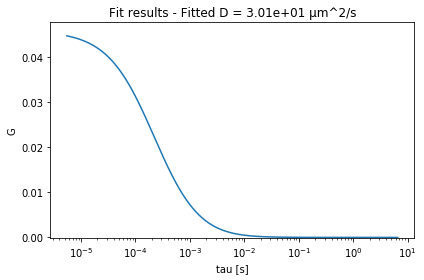

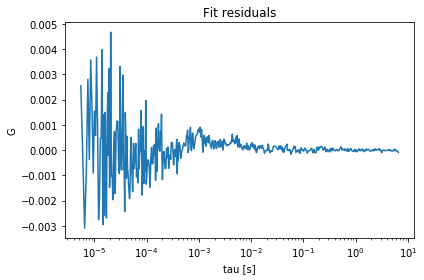

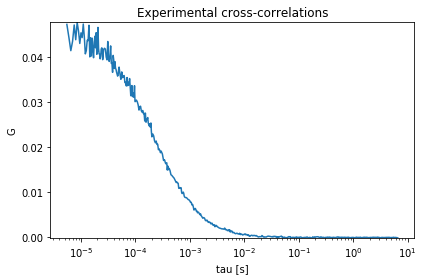

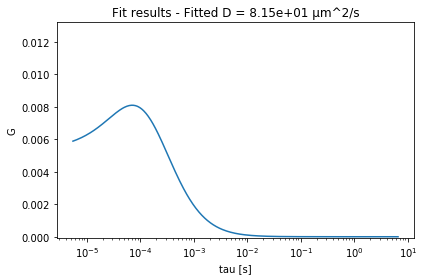

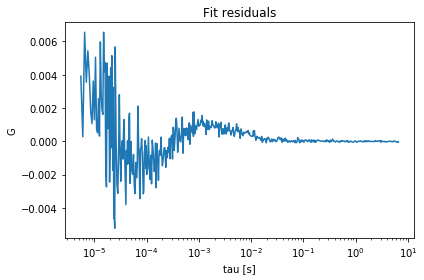

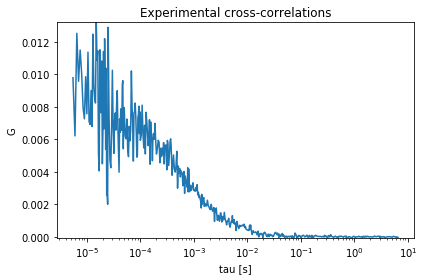

In [11]:
Ncurves = 1 # only one curve at a time is fitted
fitInfo = np.concatenate(([1], [1], np.zeros(Ncurves), np.zeros(Ncurves), np.zeros(Ncurves), np.zeros(Ncurves), [0], [0], np.zeros(Ncurves)))

start = 11
taufit = G.det0x0_average[start:, 0]
for j in [0, 4]: # fit first (delta_r = 1) and last (delta_r = 2*sqrt(2)) curve separately
    rhoxSingle = rhox[j]
    rhoySingle = rhoy[j]
    param = np.concatenate(([1], [1], [w0Central], [SFCentral], [pxsize*rhoxSingle], [pxsize*rhoySingle], [0], [0], np.zeros(1)))
    fitresult = FCSfitDualFocus(Gcolumns[start:,j], taufit, fitInfo, param)

## STICS analysis with iMSD

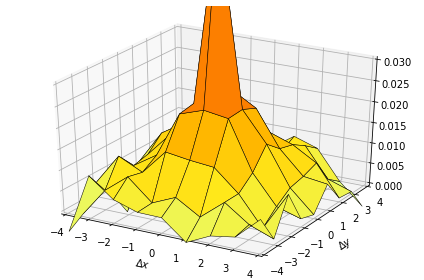

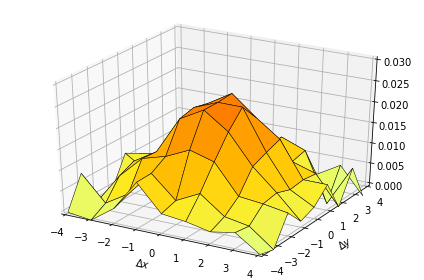

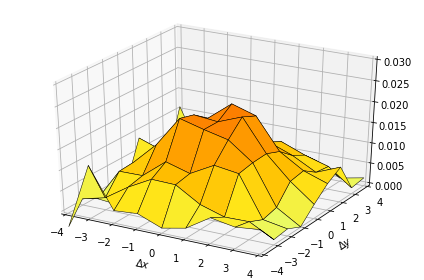

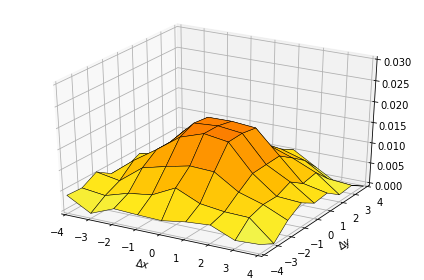

In [14]:
start = 0
Gstics = G.spatialCorr[:,:,start:]
taustics = G.det0x0_average[start:,0]
Nt = np.shape(Gstics)[2]
Nx = np.shape(Gstics)[1]
Ny = np.shape(Gstics)[0]

x = np.linspace(-np.floor(Nx/2), np.floor(Nx/2), Nx)
y = np.linspace(-np.floor(Ny/2), np.floor(Ny/2), Ny)
xv, yv = np.meshgrid(x, y)

for tauplot in [5, 10, 40, 80]:
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    if tauplot != 5:
        Gstics[4, 4, tauplot] = Gstics[3, 4, tauplot]
    ax.plot_surface(xv, yv, Gstics[:,:, tauplot], cmap='Wistia', edgecolor='black', linewidth=0.5)
    ax.set_xlabel('$\Delta x$')
    ax.xaxis._axinfo['label']['space_factor'] = 2.8
    ax.set_ylabel('$\Delta y$')
    ax.set_xlim([np.min(x), np.max(x)])
    ax.set_ylim([np.min(x), np.max(x)])
    ax.set_zlim([0, 0.03])
    plt.tight_layout()
    plt.show()

# [x0, y0, A, sigma, offset]
allfitresults = np.zeros((np.shape(Gstics)[2], 4))
weights = np.ones((9, 9))
weights[4, 4] = 0
fitInfo = [0, 0, 1, 1, 1]
for i in range(np.shape(Gstics)[2]):
    y = Gstics[:,:,i]
    fitresult = fitGauss2D(y, fitInfo, [4, 4, 0.1, 1, 0], weights)
    allfitresults[i,0:3] = fitresult.x

D from slope: 27.82 µm^2/s
w0 from intercept: 187 nm


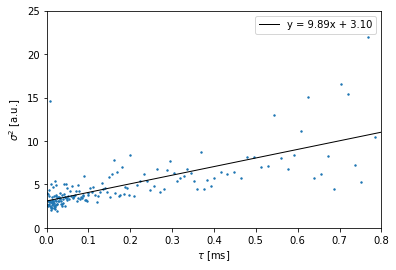

In [15]:
sigma2 = allfitresults[:,1]**2
taums = 1e3 * taustics
taumax = 0.8

[dummy, startlinfit] = findNearest(taums, 0.001)
[dummy, stoplinfit] = findNearest(taums, taumax)
taumsfit = taums[startlinfit:stoplinfit]
sigma2fit = sigma2[startlinfit:stoplinfit]

# remove outliers
idxGood = sigma2fit < 100
sigma2fit = sigma2fit[idxGood]
taumsfit = taumsfit[idxGood]

linfit = np.polyfit(taumsfit, sigma2fit, 1)
xfit = np.array([0, np.max(taums)])
yfit = linfit[0] * xfit + linfit[1]

fig = plt.figure()
plt.scatter(taumsfit, sigma2fit, s=2)
plt.plot(xfit, yfit, c='k', linewidth=1)
plt.xlabel(r'$\tau$ [ms]')
plt.ylabel('$\sigma^2$ [a.u.]')
plt.xlim([0, taumax])
plt.ylim([0, 25])
plt.legend(['y = ' + '{:.2f}'.format(linfit[0]) + 'x' + ' + {:.2f}'.format(linfit[1])])

print('D from slope: ' + '{:.2f}'.format(1e12*(linfit[0]*(75e-9)**2)/2e-3) + ' µm^2/s')
print('w0 from intercept: ' + '{:.0f}'.format(1e9*np.sqrt(2*linfit[1]*(75e-9)**2)) + ' nm')